<a href="https://colab.research.google.com/github/nhlong1512/IS403.N21/blob/main/Lab4/Lab4_ARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [58]:
dff = pd.read_csv('vnindex.csv')
df = dff.loc[::-1].reset_index(drop=True)
print(df)

          Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0     4/1/2022   1525.58  1,508.55  1,526.69  1,507.19  891.30K      1.82%
1     5/1/2022   1522.50  1,525.58  1,535.82  1,522.50    1.06M     -0.20%
2     6/1/2022   1528.57  1,522.50  1,536.24  1,518.18    1.13M      0.40%
3     7/1/2022   1528.48  1,534.10  1,534.52  1,524.96    1.03M     -0.01%
4    10/1/2022   1503.71  1,528.48  1,536.45  1,503.71    1.38M     -1.62%
..         ...       ...       ...       ...       ...      ...        ...
330   8/5/2023   1053.44  1,040.31  1,053.44  1,040.31  655.53K      1.26%
331   9/5/2023   1055.03  1,055.42  1,058.71  1,052.68  526.92K      0.15%
332  10/5/2023   1057.26  1,055.62  1,058.67  1,053.34  678.77K      0.21%
333  11/5/2023   1057.24  1,058.26  1,063.69  1,056.72  674.32K      0.00%
334  12/5/2023   1064.64  1,057.12  1,065.08  1,053.97  677.99K      0.70%

[335 rows x 7 columns]


Kiểm tra tính dừng 
<br/>
**ADF Statistic**: giá trị thống kê của Augmented Dickey-Fuller Test, được sử dụng để kiểm tra tính dừng của chuỗi thời gian. Nếu giá trị này nhỏ hơn các giá trị ngưỡng (được xác định theo mức ý nghĩa của kiểm định), thì có thể kết luận rằng chuỗi thời gian là có tính dừng.


In [59]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Lần cuối'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.661120
p-value: 0.451248


Vì p-values > 0.05 nên chúng ta sẽ thực hiện sai phân xem biểu đồ tương quan hoạt động như thế nào.

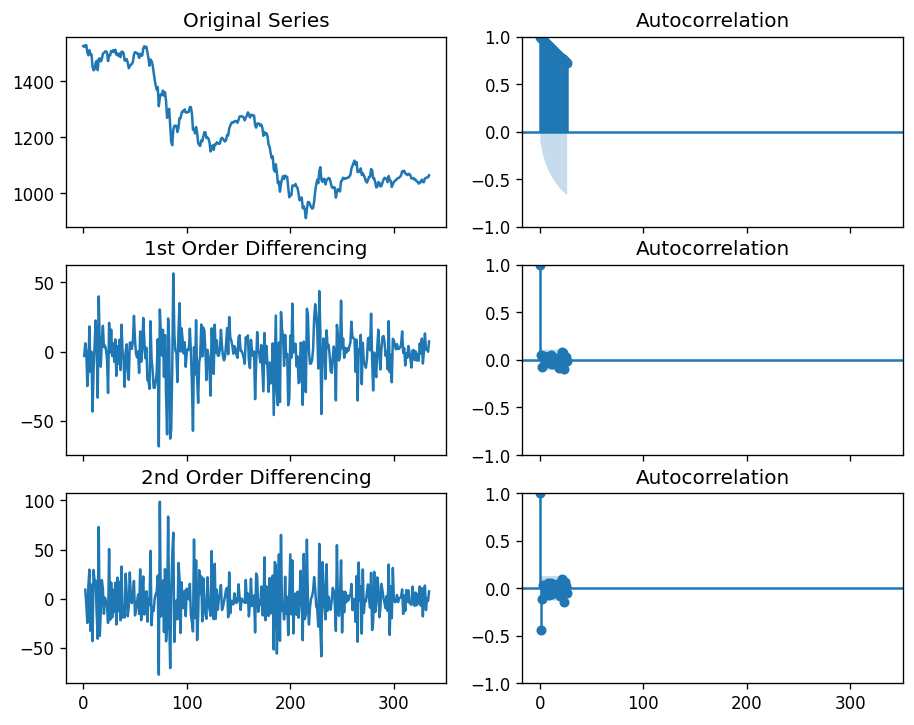

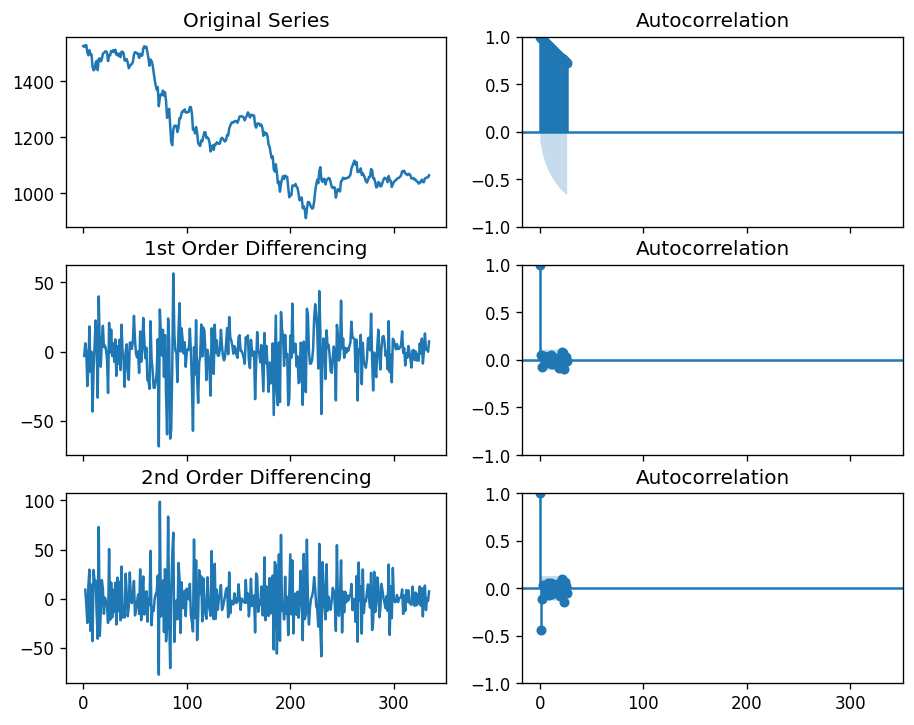

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['Lần cuối']); axes[0, 0].set_title('Original Series')
plot_acf(df['Lần cuối'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Lần cuối'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Lần cuối'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Lần cuối'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Lần cuối'].diff().diff().dropna(), ax=axes[2, 1])



**<h3>Xác định p (AR) dựa trên PACF</h3>**

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


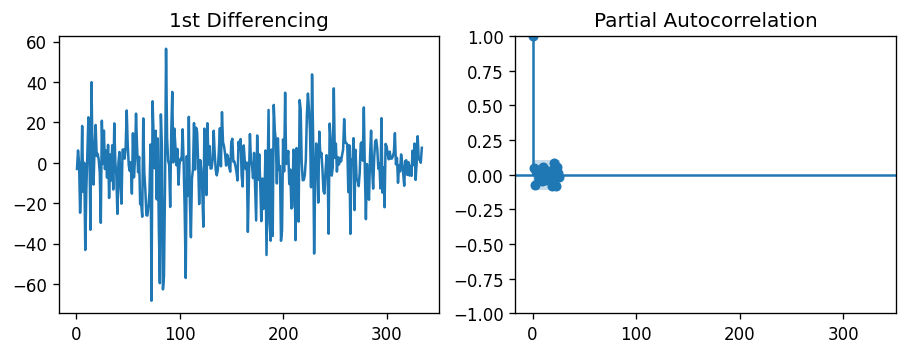

In [61]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['Lần cuối'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df['Lần cuối'].diff().dropna(), ax=axes[1])

plt.show()

**<h3>Xác định q (MA) dựa trên ACF</h3>**

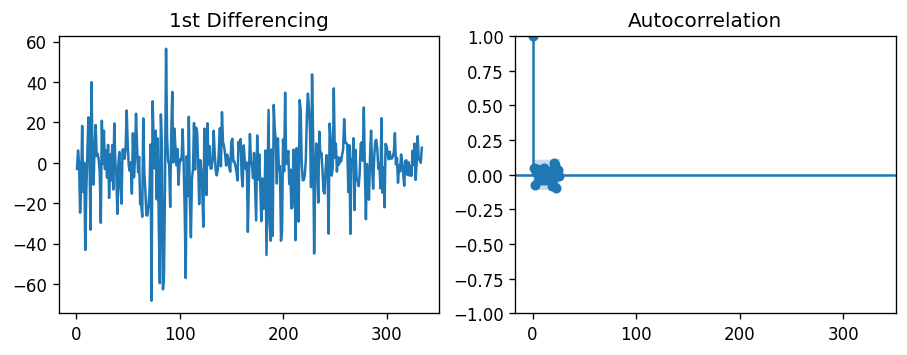

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['Lần cuối'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df['Lần cuối'].diff().dropna(), ax=axes[1])

plt.show()

Chúng ta có thể thấy rằng giá trị ACF của lag 1 là khá đáng kể vì nó nằm trên đường ý nghĩa. Vì vậy, chúng ta sẽ xác định giá trị của q là 1.

In [63]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [64]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Lần cuối'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2040.154, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2035.830, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2036.916, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2036.697, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2036.500, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2036.664, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.527 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [66]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Lần cuối'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Lần cuối'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [67]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1049.77665236 1047.74330472 1045.70995708 1043.67660944 1041.6432618
 1039.60991416 1037.57656652 1035.54321888 1033.50987124 1031.47652361
 1029.44317597 1027.40982833 1025.37648069 1023.34313305 1021.30978541
 1019.27643777 1017.24309013 1015.20974249 1013.17639485 1011.14304721
 1009.10969957 1007.07635193 1005.04300429 1003.00965665 1000.97630901
  998.94296137  996.90961373  994.87626609  992.84291845  990.80957082]


In [68]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 44.130690907012195
Testing RMSE: 84.08597153028593


Validation RMSE: 44.130690907012195
Testing RMSE: 84.08597153028593


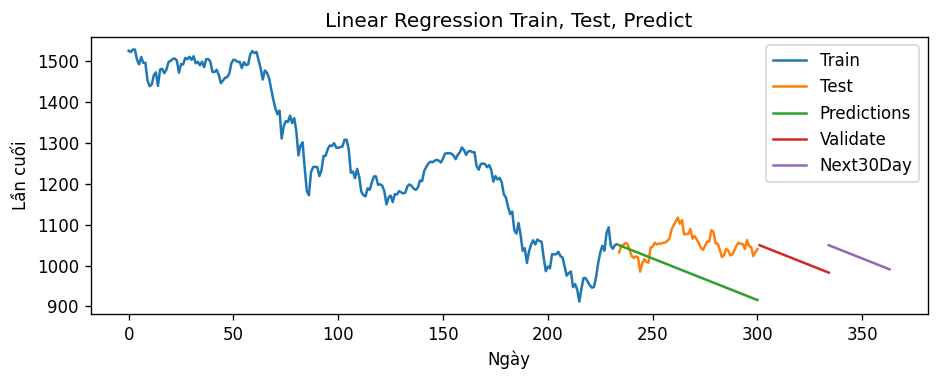

In [69]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.ylabel('Lần cuối');
plt.xlabel('Ngày');
plt.title('Linear Regression Train, Test, Predict')
plt.plot(train_data.index, train_data['Lần cuối'])
plt.plot(test_data.index, test_data['Lần cuối'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [70]:
test_data.index

RangeIndex(start=234, stop=301, step=1)